<a href="https://colab.research.google.com/github/madhurima99/datascience-mashup/blob/main/Voice-Gender%20identification/Gender_Voice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">Voice-Based Gender Identification </h1>
<p align="center">
In this notebook a set of acoustic and pitch features of voice along with different classifiers are compared for the problem of gender identification.
</p>

<h2>Import Dataset</h2>
<p>The dataset for this notebook is imported from Kaggle, <a href="https://www.kaggle.com/primaryobjects/voicegender">Gender Recognition by Voice</a>. <br>
The following blocks of codes are used to import dataset from Kaggle.</p>

In [1]:
#upload Kaggle API Token containing in a json file
from google.colab import files
files.upload()

{}

Note: I have hidden my Kaggle API key. While running this, please use your own API key.

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#change permission
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d primaryobjects/voicegender

voicegender.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
from zipfile import ZipFile
file_name = "voicegender.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


<h2>Import necessary libraries </h2>

In [5]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

<h2>Load Data</h2>

In [6]:
data = pd.read_csv("voice.csv")
data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [7]:
print("Shape of the dataset: ", data.shape)

Shape of the dataset:  (3168, 21)


<h2>Visualizing and Analyzing data</h2>

In [8]:
#check null values
data.isnull().sum()

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64

The dataset doesn't contain any NAN values.

In [9]:
#check basic descriptions
data.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000
mean,0.180907,0.057126,0.185621,0.140456,0.224765,0.084309,3.140168,36.568461,0.895127,0.408216,0.165282,0.180907,0.142807,0.036802,0.258842,0.829211,0.052647,5.047277,4.994630,0.173752
std,0.029918,0.016652,0.036360,0.048680,0.023639,0.042783,4.240529,134.928661,0.044980,0.177521,0.077203,0.029918,0.032304,0.019220,0.030077,0.525205,0.063299,3.521157,3.520039,0.119454
min,0.039363,0.018363,0.010975,0.000229,0.042946,0.014558,0.141735,2.068455,0.738651,0.036876,0.000000,0.039363,0.055565,0.009775,0.103093,0.007812,0.004883,0.007812,0.000000,0.000000
25%,0.163662,0.041954,0.169593,0.111087,0.208747,0.042560,1.649569,5.669547,0.861811,0.258041,0.118016,0.163662,0.116998,0.018223,0.253968,0.419828,0.007812,2.070312,2.044922,0.099766
50%,0.184838,0.059155,0.190032,0.140286,0.225684,0.094280,2.197101,8.318463,0.901767,0.396335,0.186599,0.184838,0.140519,0.046110,0.271186,0.765795,0.023438,4.992188,4.945312,0.139357
75%,0.199146,0.067020,0.210618,0.175939,0.243660,0.114175,2.931694,13.648905,0.928713,0.533676,0.221104,0.199146,0.169581,0.047904,0.277457,1.177166,0.070312,7.007812,6.992188,0.209183
max,0.251124,0.115273,0.261224,0.247347,0.273469,0.252225,34.725453,1309.612887,0.981997,0.842936,0.280000,0.251124,0.237636,0.204082,0.279114,2.957682,0.458984,21.867188,21.843750,0.932374


In [10]:
#apply label encoder to label col
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
data['label'] = enc.fit_transform(data['label'].astype('str'))

data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,1
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,1
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,1
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,1
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,1


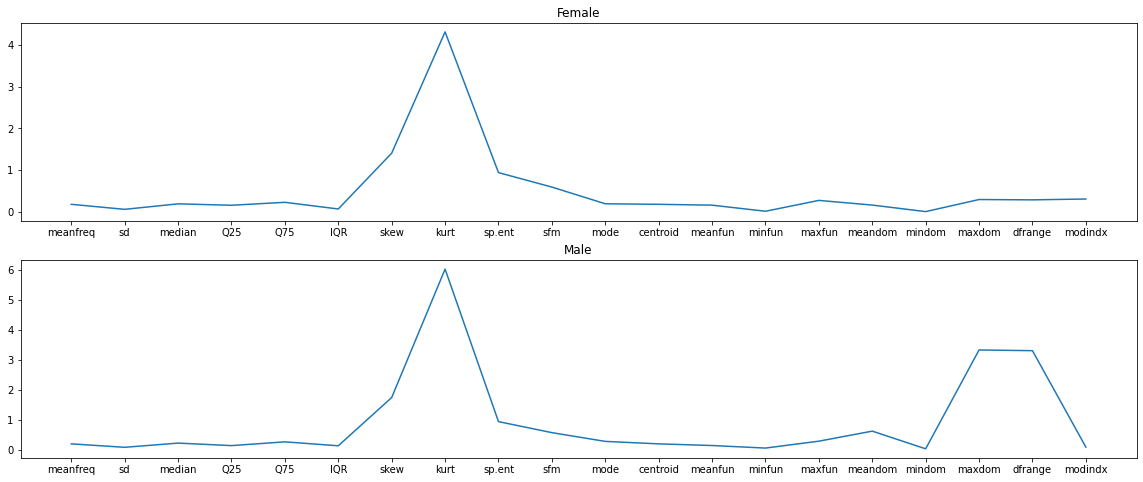

In [11]:
#plotting line graph
index = 0
label = ['Female', 'Male']

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(20,8))

for i in range(2):
  ax[i].plot(data[data['label'] == i].sample(1).iloc[0,:20])
  ax[i].set_title(label[i],)

The above graphs clearly shows, Kurt is genrally high for males as compared to females whereas Maxdom and Dfrange are quite low. These attributes are essential for classfication of data

Let's further see how other attributes are related to each other using correlation matrix and pairplot.

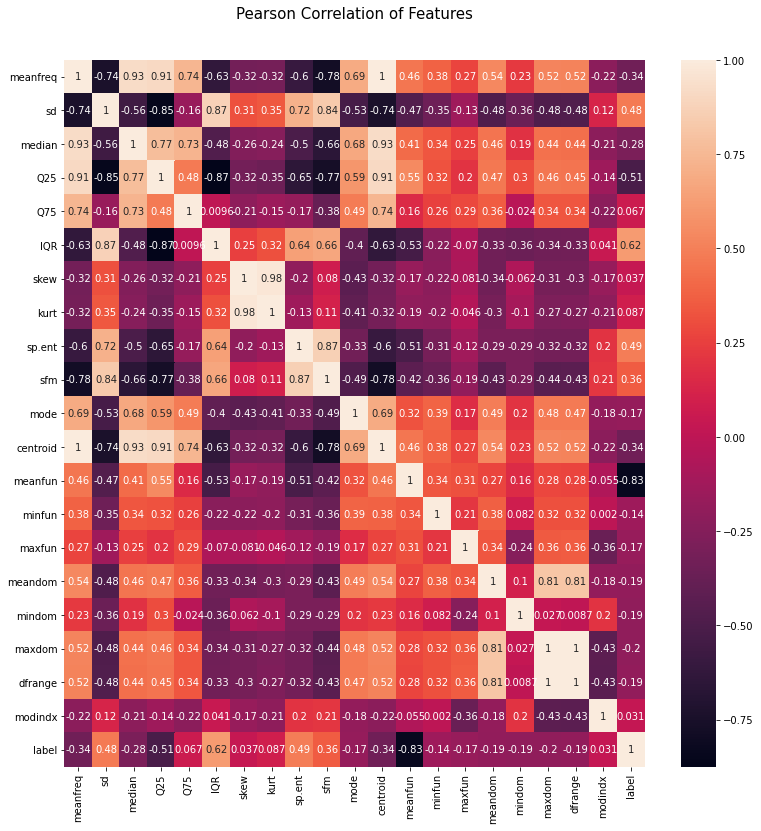

In [12]:
#Plotting correlation table
corr_data = data.corr()
plt.figure(figsize=(13,13))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(corr_data, annot = True)

In [13]:
# function to get the name of highest corelated attributes

def get_highest_corr(cor_dat, threshold): 
  #Cor_data to be column along which corelation to be measured 
  #threshold be the value above wich of corelation to considered
  feature=[]
  value=[]

  for i ,index in enumerate(cor_dat.index):
    if abs(cor_dat[index]) > threshold:
      feature.append(index)
      value.append(cor_dat[index])

  df = pd.DataFrame(data = value, index = feature, columns=['corr value'])
  return df

In [14]:
highest_corr = get_highest_corr(corr_data['label'], 0.30)
highest_corr

,corr value
meanfreq,-0.337415
sd,0.479539
Q25,-0.511455
IQR,0.618916
sp.ent,0.490552
sfm,0.357499
centroid,-0.337415
meanfun,-0.833921
label,1.000000


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


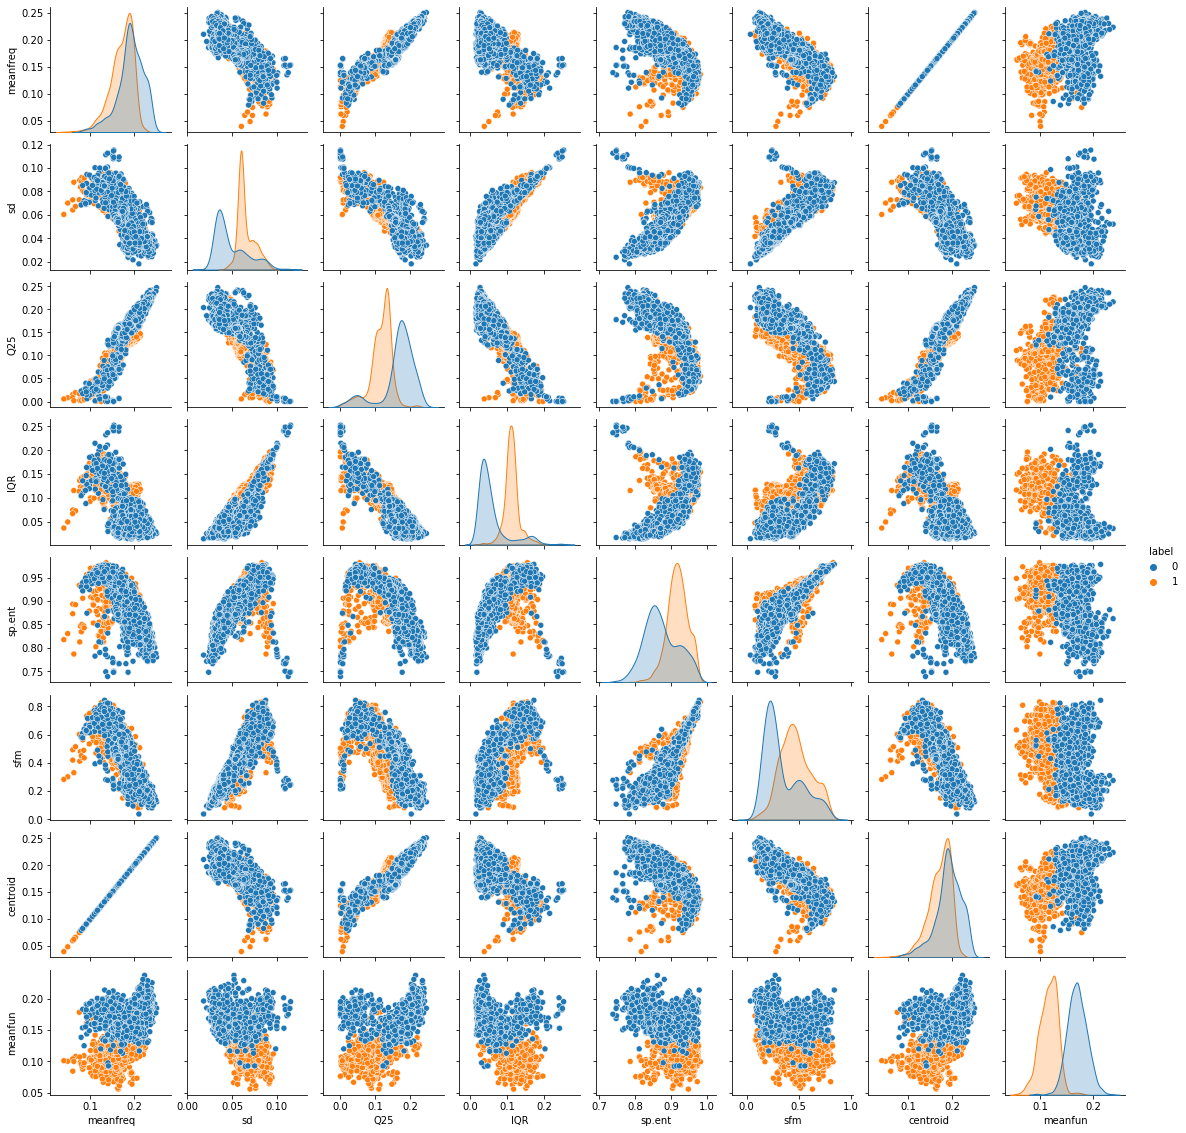

In [15]:
#plotting pairplot of attributes shown in heatmap most related to attribute label.
sns.pairplot(data[highest_corr.index], hue='label', size=2)

Here diagonal of pairplot depicts how both the classes are correlated with these attributes so nicely , thus they are perfect for using in classification.<br>

Other plots also shows nice correlation with each other and how both classes are easily saparable over these columns. <br>

So for classification these attributes plus **Kurt, Maxdom and Dfrange** will be used since they are also seems essential from the line plot.

<h2>Preparing Data</h2>

In [16]:
#Seperate Features and Labels
X = data[list(highest_corr.index[:-1]) + [ 'kurt', 'maxdom', 'dfrange']]
y = data['label']

In [17]:
#Label encoding
#y=y.map({'male':0,'female':1})

In [18]:
#Standardisation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [19]:
#Split the dataset into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

<h2>Model Creation</h2>

Here, 3 models has been used to find the best fit.

<b>1. Decision Tree Classifier(DTC)</b>

In [20]:
from sklearn import tree
dt_model = tree.DecisionTreeClassifier()
dt_model.fit(X_train,y_train)
y_dt = dt_model.predict(X_test)
score_dt = round(accuracy_score(y_test,y_dt)*100, 3)
print("Accuracy score: ",score_dt,"%")
print("\nConfusion Matrix: \n",confusion_matrix(y_test,y_dt))
print("\nClassification Report: \n",classification_report(y_test,y_dt))

Accuracy score:  97.003 %

Confusion Matrix: 
 [[291  10]
 [  9 324]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       301
           1       0.97      0.97      0.97       333

    accuracy                           0.97       634
   macro avg       0.97      0.97      0.97       634
weighted avg       0.97      0.97      0.97       634



<b>2. Support Vector Machine(SVM)</b>

In [21]:
from sklearn import svm
svm_model = svm.SVC()
svm_model.fit(X_train, y_train)
y_svm = svm_model.predict(X_test)
score_svm = round(accuracy_score(y_test,y_svm)*100, 3)
print("Accuracy score: ",score_svm,"%")
print("\nConfusion Matrix: \n",confusion_matrix(y_test,y_svm))
print("\nClassification Report: \n",classification_report(y_test,y_svm))

Accuracy score:  98.107 %

Confusion Matrix: 
 [[294   7]
 [  5 328]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       301
           1       0.98      0.98      0.98       333

    accuracy                           0.98       634
   macro avg       0.98      0.98      0.98       634
weighted avg       0.98      0.98      0.98       634



<b>3. Deep Neural Network(DNN)</b>

In [22]:
#defining input dimension for the model
n_cols = X_train.shape[1]

In [23]:
#model creation
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', input_dim = n_cols),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')    
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              12288     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 701,441
Trainable params: 701,441
Non-trainable params: 0
__________________________________________________

In [25]:
#Compiling the model
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
#model fitting
history = model.fit(X_train, y_train, epochs = 50, validation_split = 0.1)

Epoch 1/50
72/72 [==============================] - 2s 20ms/step - loss: 0.2370 - accuracy: 0.9056 - val_loss: 0.1952 - val_accuracy: 0.9409
Epoch 2/50
72/72 [==============================] - 1s 14ms/step - loss: 0.0985 - accuracy: 0.9651 - val_loss: 0.1078 - val_accuracy: 0.9606
Epoch 3/50
72/72 [==============================] - 1s 14ms/step - loss: 0.0626 - accuracy: 0.9803 - val_loss: 0.0807 - val_accuracy: 0.9685
Epoch 4/50
72/72 [==============================] - 1s 14ms/step - loss: 0.0643 - accuracy: 0.9814 - val_loss: 0.0940 - val_accuracy: 0.9724
Epoch 5/50
72/72 [==============================] - 1s 15ms/step - loss: 0.0703 - accuracy: 0.9777 - val_loss: 0.1005 - val_accuracy: 0.9685
Epoch 6/50
72/72 [==============================] - 1s 15ms/step - loss: 0.0548 - accuracy: 0.9833 - val_loss: 0.0637 - val_accuracy: 0.9803
Epoch 7/50
72/72 [==============================] - 1s 14ms/step - loss: 0.0577 - accuracy: 0.9814 - val_loss: 0.0937 - val_accuracy: 0.9724
Epoch 8/50
72

In [27]:
#evaluation on test dataset
score_dn = model.evaluate(X_test,y_test)
score_dn = round(score_dn[1]*100,3)

20/20 [==============================] - 0s 3ms/step - loss: 0.1429 - accuracy: 0.9858


In [28]:
score = model.evaluate(x = X_train, y = y_train, verbose = 0)
print('Accuracy for train set:', round(score[1]*100, 3), '%')
score_val_dn = history.history['val_accuracy']
score_val_dn = round(score_val_dn[1]*100,3)
print('Accuracy for evaluation set:', score_val_dn, '%')
print('Accuracy for test set:', score_dn, '%')

Accuracy for train set: 99.684 %
Accuracy for evaluation set: 96.063 %
Accuracy for test set: 98.58 %


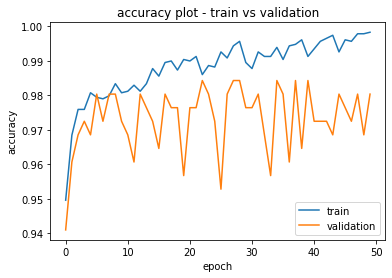

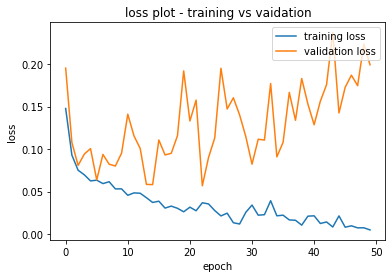

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation'], loc='lower right')
plt.title('accuracy plot - train vs validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'], loc = 'upper right')
plt.title('loss plot - training vs vaidation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

<h2>Comparing the models</h2>


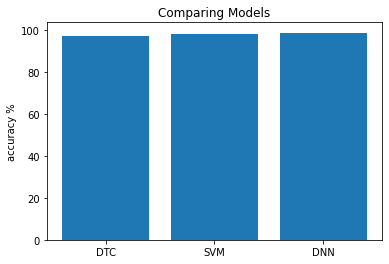

In [30]:
from matplotlib.ticker import FuncFormatter

x = np.arange(3)
accuracy = [score_dt,score_svm,score_dn]

fig, ax = plt.subplots()
plt.bar(x, accuracy)
plt.xticks(x, ('DTC','SVM','DNN'))
ax.set_ylabel('accuracy %')
ax.set_title('Comparing Models')
plt.show()

Out of the 3 models, SVM and DNN model both performs well to predict gender from acoustic properties of the voice and speech. While SVM model has an accuracy of 98.11%, the DNN model acquires an accuracy of 98.58% on test dataset. Hence, the model built using deep neural network with highest accuracy is preferable for voice based gender identification.